<a href="https://colab.research.google.com/github/deebuls/devblog/blob/main/posts/notebooks/2023-03-09-Neural-Link-Model-Uncertainty-Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
title: "Neural Linear Model (aka Gaussian Process)"
author: "Andrew Jesson, Deebul Nair"
date: "3/9/2023"
jupyter: python3
image: images/neural_linear_model.png
format: 
  html:
    code-fold: false
---

# Marginalized Neural Network (aka Neural Linear Model)

Based on the tweet by [Andrew Jesson](https://twitter.com/anndvision/status/1617398841950760961). Below is from the notebook shared by Andrew.

Thanks to [David Holzmüller](https://twitter.com/DHolzmueller/status/1617811316340830208?s=20), [Kevin Patrick Murphy](https://twitter.com/sirbayes/status/1617703912731181062?s=20), and [Jason Hartford
](https://twitter.com/jasonhartford/status/1617708456261349377?s=20) for correctly identifying this approach as the Neural Linear Model (NLM). The NLM seems to have first appeared as the Marginalized Neural Network in [Marginalized Neural Network Mixtures for Large-Scale Regression](https://ieeexplore.ieee.org/abstract/document/5499041) and then in [Scalable Bayesian Optimization Using Deep Neural Networks](http://proceedings.mlr.press/v37/snoek15.html). [Benchmarking the Neural Linear Model for Regression](https://arxiv.org/abs/1912.08416) compares the NLM to mean field variational inference and Monte Carlo dropout Bayesian Neural Networks and concludes that methods such as NLM which do exact inference over a subset of parameters may perform better than methods that do variational inference over all parameters.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch.nn.functional import softplus

rc = {
    "figure.constrained_layout.use": True,
    "axes.titlesize": 20,
    "figure.figsize": (12, 9),
}
sns.set_theme(style="darkgrid", palette="colorblind", rc=rc)

In [43]:
class Simulated(torch.utils.data.Dataset):
    def __init__(self, n=1000, sigma=0.1, in_between=False, outliers_percentage=None):
        if in_between:
            mask = torch.distributions.Bernoulli(0.5).sample(torch.Size([n, 1]))
            self.data = (-2 * torch.rand(n, 1).float() - 1) * mask \
                + (2 * torch.rand(n, 1).float() + 1) * (1. - mask)
        else:
            self.data = torch.randn(n, 1).float()
        self.targets = f(self.data, sigma).float()
        #Adding outliers
        if (outliers_percentage):
          num_outliers = int((outliers_percentage/100) * n)
          outliers = torch.distributions.Uniform(
              torch.tensor([-5.0]), torch.tensor([5.0])).sample(torch.Size([num_outliers]))
          mask = torch.randint_like(outliers, high=n).long()
          #print(outliers)
          self.targets[mask] = outliers.float()


    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]


def f(x, sigma=0.1):
    w = torch.tensor([-0.6667, -0.6012, -1.0172, -0.7687, 1.4680, -0.1678])
    fx = 0
    for i in range(len(w)):
        fx += w[i] * (x**i)
    fx *= np.sin(np.pi * x)
    fx *= np.exp(-0.5 * (x**2)) / np.sqrt(2 * np.pi)
    return (
        fx.squeeze(-1)
        + torch.randn(
            len(x),
        )
        * sigma
    )


In [62]:
num_features = 100
n_train = 200
dr = 0.05

model = torch.nn.Sequential(
    torch.nn.Linear(1, num_features),
    torch.nn.ReLU(),
    torch.nn.Dropout(dr),
    torch.nn.Linear(num_features, num_features),
    torch.nn.ReLU(),
    torch.nn.Dropout(dr),
    torch.nn.Linear(num_features, num_features),
    torch.nn.ReLU(),
    torch.nn.Dropout(dr),
    torch.nn.Linear(num_features, 1),
)
log_sigma = torch.nn.Parameter(-2 * torch.ones(1))
ds = Simulated(n=n_train)
dl = torch.utils.data.DataLoader(
    ds,
    batch_size=32,
    shuffle=True,
    drop_last=True
)
optimizer = torch.optim.AdamW(
    [
        
        {
            "params": model.parameters(),
            "lr": 1e-3,
            "weight_decay": (1 - dr)
            / (2 * len(ds)),
        },
        {
            "params": log_sigma,
            "lr": 1e-2,
            "weight_decay": 1e-6,
        },
    ]
)

In [63]:
model.train()
for epoch in range(500):
  train_loss = []
  for batch in dl:
    x, y = batch
    mu = model(x)
    dist = torch.distributions.Normal(mu, softplus(log_sigma))
    loss = -dist.log_prob(y.unsqueeze(-1)).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
  if epoch % 20 == 0:
    print(f"Epoch {epoch}, loss: {np.mean(train_loss):.02f}")

Epoch 0, loss: 2.83
Epoch 20, loss: 0.10
Epoch 40, loss: -0.08
Epoch 60, loss: -0.28
Epoch 80, loss: -0.36
Epoch 100, loss: -0.38
Epoch 120, loss: -0.48
Epoch 140, loss: -0.67
Epoch 160, loss: -0.67
Epoch 180, loss: -0.63
Epoch 200, loss: -0.73
Epoch 220, loss: -0.67
Epoch 240, loss: -0.70
Epoch 260, loss: -0.76
Epoch 280, loss: -0.71
Epoch 300, loss: -0.58
Epoch 320, loss: -0.84
Epoch 340, loss: -0.75
Epoch 360, loss: -0.79
Epoch 380, loss: -0.83
Epoch 400, loss: -0.79
Epoch 420, loss: -0.71
Epoch 440, loss: -0.62
Epoch 460, loss: -0.74
Epoch 480, loss: -0.89


## Computing uncertainty
Need to compute $\phi(X_{\text{test}})$ and $\phi(X_{\text{train}})$

In [64]:
x_test = torch.linspace(-4, 4, 150).unsqueeze(-1)
model.eval()
with torch.no_grad():
    mu_pred = model(x_test)
    phi_test = model[:-1](x_test)
    phi_train = model[:-1](ds.data)
print(phi_train.shape, phi_test.shape)

torch.Size([200, 100]) torch.Size([150, 100])


Now we calculate, $\sigma^{-2}\phi(X_{\text{train}})^{⊤} \phi(X_{\text{train}}) + \mathbf{I}$, which has shape num_features x num_features. This is different from a standard GP with size n_train x n_train.

In [65]:
I = torch.eye(num_features)
A = phi_train.T @ phi_train / torch.square(softplus(log_sigma).detach())  + I

Now we solve for $\phi(x)^{\top}\left(\sigma^{-2}\phi(X_{\text{train}})^{⊤} \phi(X_{\text{train}}) + \mathbf{I}\right)^{-1}\phi(x)$. We can use the identity $\phi(x)^{\top}\left(\sigma^{-2}\phi(X_{\text{train}})^{⊤} \phi(X_{\text{train}}) + \mathbf{I}\right)^{-1}\phi(x) = ||L^{-1}\phi(x)||^2_2$, with $L$ the Cholesky decomposition of $\left(\sigma^{-2}\phi(X_{\text{train}})^{⊤} \phi(X_{\text{train}}) + \mathbf{I}\right)^{-1}$. Thank you Andreas Kirsch.

As pointed out by [Yarin Gal](https://twitter.com/yaringal/status/1617441355885867008?s=46&t=qRmt95MoVGdbvfCdmK2ssA), this is in fact Bayesian Linear regression in penultimate layer feature space. Which is indeed, ["sort of a deep kernel GP."](https://twitter.com/andrewgwils/status/1617284759142469634?s=46&t=qRmt95MoVGdbvfCdmK2ssA)

In [66]:
L = torch.linalg.cholesky(A)
print(L.shape)
v = torch.linalg.solve_triangular(L, phi_test.T, upper=False)
cov = v.T @ v + 1e-5 * torch.eye(len(phi_test))
f_stddev = torch.sqrt(torch.diag(cov))

torch.Size([100, 100])


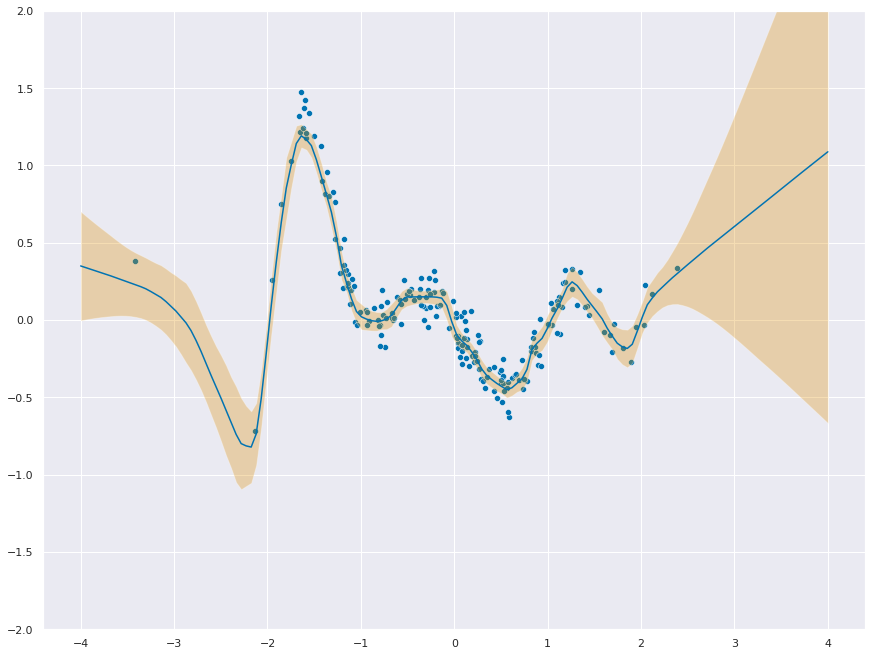

In [67]:
_ = plt.figure(figsize=(12,9))
_ = sns.scatterplot(x=ds.data.ravel(), y=ds.targets.ravel())
_ = sns.lineplot(x=x_test.ravel(), y=mu_pred.ravel())
_ = plt.fill_between(
    x=x_test.ravel(), 
    y1=mu_pred.ravel() + 1.96 * f_stddev, 
    y2=mu_pred.ravel() - 1.96 * f_stddev,
    alpha=0.3,
)
_ = plt.ylim(-2, 2)

### Pretty Samples

In [68]:
dist = torch.distributions.MultivariateNormal(loc=mu_pred.ravel(), covariance_matrix=cov)
f_samples = dist.sample(torch.Size([20]))

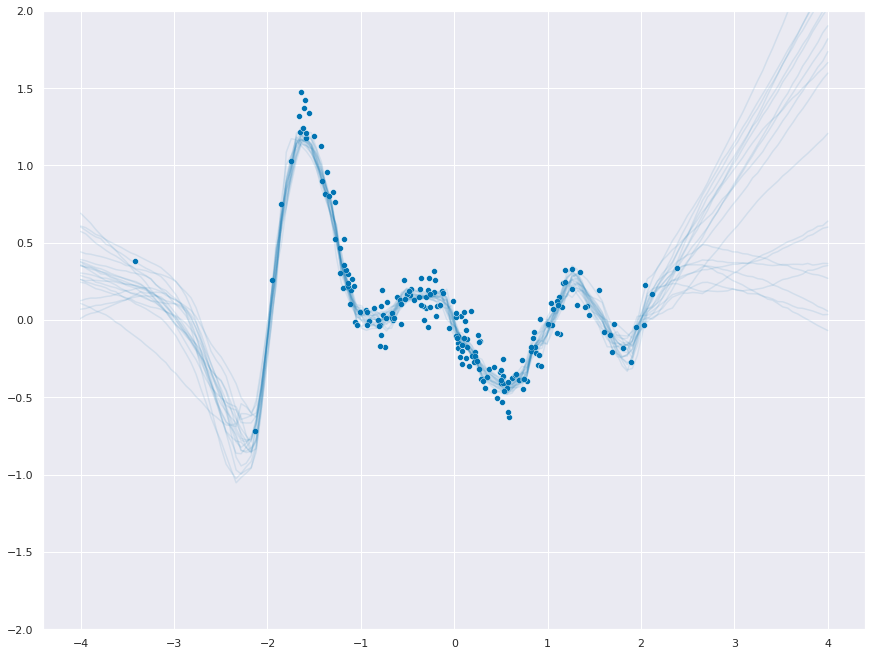

In [69]:
_ = sns.scatterplot(x=ds.data.ravel(), y=ds.targets.ravel())
for func in f_samples:
    _ = sns.lineplot(x=x_test.ravel(), y=func.to("cpu"), color="C0", alpha=0.1)
_ = plt.ylim(-2, 2)

## In-between uncertainty

[Great comment from Yingzhen Li](https://twitter.com/liyzhen2/status/1617431076225568768?s=46&t=qRmt95MoVGdbvfCdmK2ssA) on in-between uncertainty! Let's take a look.

In [71]:
num_features = 100
n_train = 200
dr = 0.05

model = torch.nn.Sequential(
    torch.nn.Linear(1, num_features),
    torch.nn.ReLU(),
    torch.nn.Dropout(dr),
    torch.nn.Linear(num_features, num_features),
    torch.nn.ReLU(),
    torch.nn.Dropout(dr),
    torch.nn.Linear(num_features, num_features),
    torch.nn.ReLU(),
    torch.nn.Dropout(dr),
    torch.nn.Linear(num_features, 1),
)
log_sigma = torch.nn.Parameter(-2 * torch.ones(1))
ds = Simulated(n=n_train, in_between=True)
dl = torch.utils.data.DataLoader(
    ds,
    batch_size=32,
    shuffle=True,
    drop_last=True
)
optimizer = torch.optim.AdamW(
    [
        
        {
            "params": model.parameters(),
            "lr": 1e-3,
            "weight_decay": (1 - dr)
            / (2 * len(ds)),
        },
        {
            "params": log_sigma,
            "lr": 1e-2,
            "weight_decay": 1e-6,
        },
    ]
)

In [72]:
model.train()
for epoch in range(500):
  train_loss = []
  for batch in dl:
    x, y = batch
    mu = model(x)
    dist = torch.distributions.Normal(mu, softplus(log_sigma))
    loss = -dist.log_prob(y.unsqueeze(-1)).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
  if epoch % 20 == 0:
    print(f"Epoch {epoch}, loss: {np.mean(train_loss):.02f}")

Epoch 0, loss: 13.52
Epoch 20, loss: 0.87
Epoch 40, loss: 0.26
Epoch 60, loss: -0.04
Epoch 80, loss: -0.14
Epoch 100, loss: -0.13
Epoch 120, loss: -0.25
Epoch 140, loss: -0.03
Epoch 160, loss: -0.42
Epoch 180, loss: -0.35
Epoch 200, loss: -0.41
Epoch 220, loss: -0.47
Epoch 240, loss: -0.36
Epoch 260, loss: -0.41
Epoch 280, loss: -0.44
Epoch 300, loss: -0.54
Epoch 320, loss: -0.48
Epoch 340, loss: -0.55
Epoch 360, loss: -0.55
Epoch 380, loss: -0.57
Epoch 400, loss: -0.46
Epoch 420, loss: -0.52
Epoch 440, loss: -0.44
Epoch 460, loss: -0.60
Epoch 480, loss: -0.52


In [73]:
x_test = torch.linspace(-4, 4, 150).unsqueeze(-1)
model.eval()
with torch.no_grad():
    mu_pred = model(x_test)
    phi_test = model[:-1](x_test)
    phi_train = model[:-1](ds.data)

I = torch.eye(num_features)
A = phi_train.T @ phi_train / torch.square(softplus(log_sigma).detach())  + I

L = torch.linalg.cholesky(A)
v = torch.linalg.solve_triangular(L, phi_test.T, upper=False)
cov = v.T @ v + 1e-5 * torch.eye(len(phi_test))
f_stddev = torch.sqrt(torch.diag(cov))

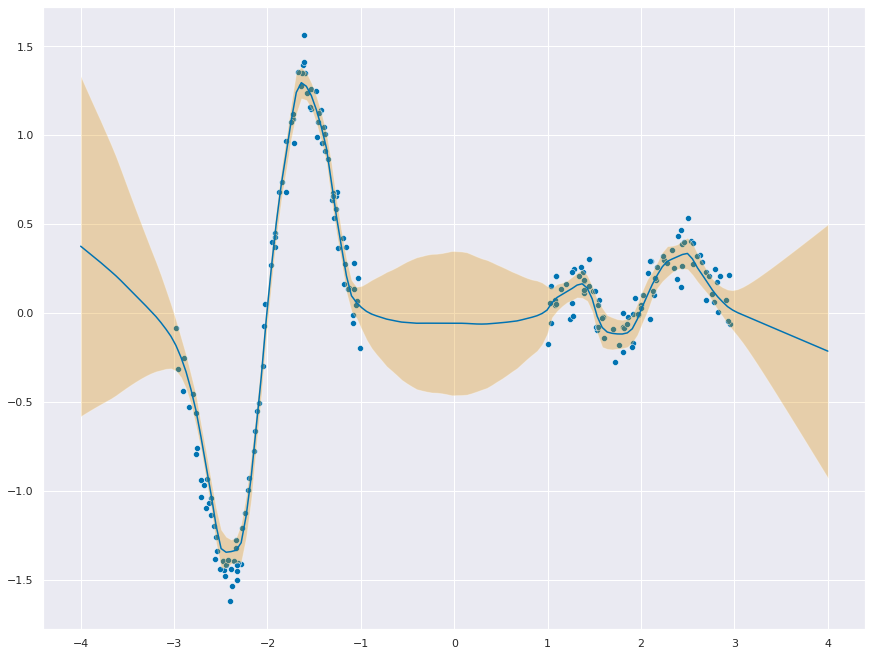

In [74]:
_ = plt.figure(figsize=(12,9))
_ = sns.scatterplot(x=ds.data.ravel(), y=ds.targets.ravel())
_ = sns.lineplot(x=x_test.ravel(), y=mu_pred.ravel())
_ = plt.fill_between(
    x=x_test.ravel(), 
    y1=mu_pred.ravel() + 1.96 * f_stddev, 
    y2=mu_pred.ravel() - 1.96 * f_stddev,
    alpha=0.3,
)

In [75]:
dist = torch.distributions.MultivariateNormal(loc=mu_pred.ravel(), covariance_matrix=cov)
f_samples = dist.sample(torch.Size([50]))

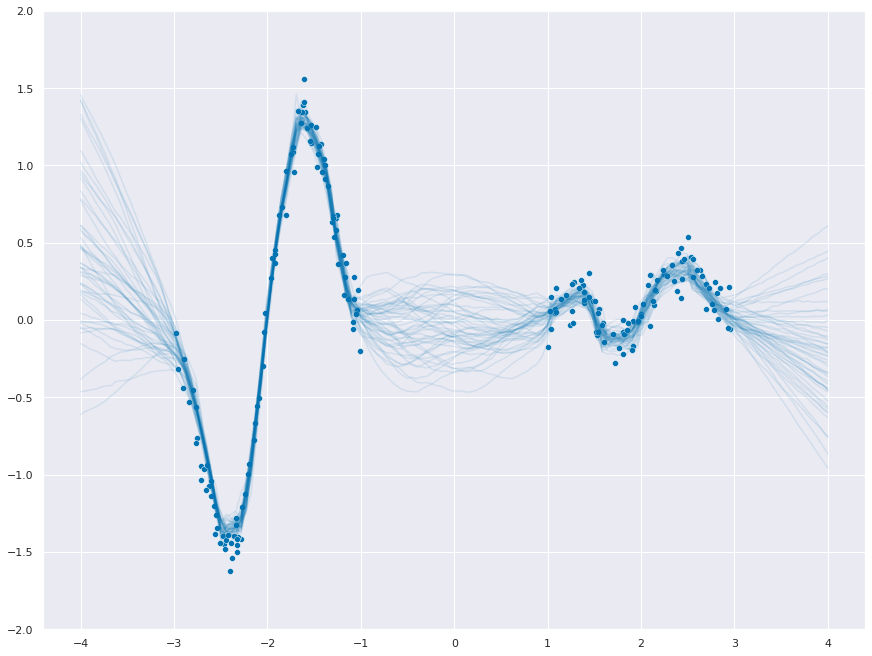

In [76]:
_ = sns.scatterplot(x=ds.data.ravel(), y=ds.targets.ravel())
for func in f_samples:
    _ = sns.lineplot(x=x_test.ravel(), y=func.to("cpu"), color="C0", alpha=0.1)
_ = plt.ylim(-2, 2)

## With Outliers 

Adding 5% outliers  : The loss increases from -0.89 to 1.27 . 


Epoch 0, loss: 25.33
Epoch 20, loss: 5.53
Epoch 40, loss: 3.51
Epoch 60, loss: 2.53
Epoch 80, loss: 2.00
Epoch 100, loss: 1.35
Epoch 120, loss: 1.61
Epoch 140, loss: 1.49
Epoch 160, loss: 1.43
Epoch 180, loss: 1.39
Epoch 200, loss: 1.33
Epoch 220, loss: 1.34
Epoch 240, loss: 1.23
Epoch 260, loss: 1.27
Epoch 280, loss: 1.21
Epoch 300, loss: 1.32
Epoch 320, loss: 1.29
Epoch 340, loss: 1.27
Epoch 360, loss: 1.29
Epoch 380, loss: 1.28
Epoch 400, loss: 1.29
Epoch 420, loss: 1.28
Epoch 440, loss: 1.22
Epoch 460, loss: 1.17
Epoch 480, loss: 1.27
torch.Size([200, 100]) torch.Size([150, 100])
torch.Size([100, 100])


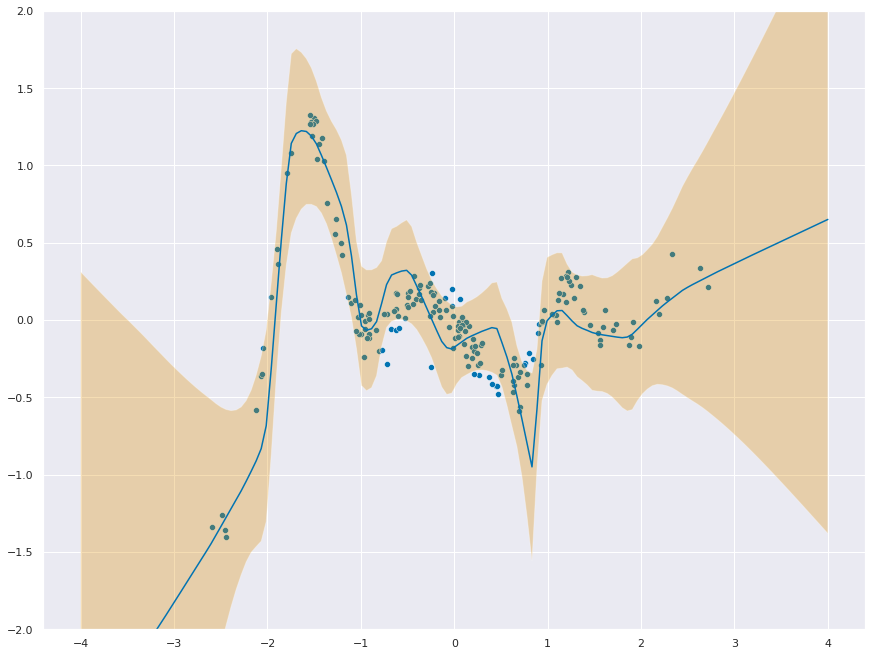

In [78]:
num_features = 100
n_train = 200
dr = 0.05

model = torch.nn.Sequential(
    torch.nn.Linear(1, num_features),
    torch.nn.ReLU(),
    torch.nn.Dropout(dr),
    torch.nn.Linear(num_features, num_features),
    torch.nn.ReLU(),
    torch.nn.Dropout(dr),
    torch.nn.Linear(num_features, num_features),
    torch.nn.ReLU(),
    torch.nn.Dropout(dr),
    torch.nn.Linear(num_features, 1),
)
log_sigma = torch.nn.Parameter(-2 * torch.ones(1))
ds = Simulated(n=n_train, outliers_percentage=5)
dl = torch.utils.data.DataLoader(
    ds,
    batch_size=32,
    shuffle=True,
    drop_last=True
)
optimizer = torch.optim.AdamW(
    [
        
        {
            "params": model.parameters(),
            "lr": 1e-3,
            "weight_decay": (1 - dr)
            / (2 * len(ds)),
        },
        {
            "params": log_sigma,
            "lr": 1e-2,
            "weight_decay": 1e-6,
        },
    ]
)

model.train()
for epoch in range(500):
  train_loss = []
  for batch in dl:
    x, y = batch
    mu = model(x)
    dist = torch.distributions.Normal(mu, softplus(log_sigma))
    loss = -dist.log_prob(y.unsqueeze(-1)).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
  if epoch % 20 == 0:
    print(f"Epoch {epoch}, loss: {np.mean(train_loss):.02f}")

x_test = torch.linspace(-4, 4, 150).unsqueeze(-1)
model.eval()
with torch.no_grad():
    mu_pred = model(x_test)
    phi_test = model[:-1](x_test)
    phi_train = model[:-1](ds.data)
print(phi_train.shape, phi_test.shape)

I = torch.eye(num_features)
A = phi_train.T @ phi_train / torch.square(softplus(log_sigma).detach())  + I

L = torch.linalg.cholesky(A)
print(L.shape)
v = torch.linalg.solve_triangular(L, phi_test.T, upper=False)
cov = v.T @ v + 1e-5 * torch.eye(len(phi_test))
f_stddev = torch.sqrt(torch.diag(cov))

_ = plt.figure(figsize=(12,9))
_ = sns.scatterplot(x=ds.data.ravel(), y=ds.targets.ravel())
_ = sns.lineplot(x=x_test.ravel(), y=mu_pred.ravel())
_ = plt.fill_between(
    x=x_test.ravel(), 
    y1=mu_pred.ravel() + 1.96 * f_stddev, 
    y2=mu_pred.ravel() - 1.96 * f_stddev,
    alpha=0.3,
)
_ = plt.ylim(-2, 2)